<font size=5> **MTH9831 Homework4 Numerical Projects** </font>

<font size=3> **Team members:** </font>
- Chu, Gujia
- Twahir, Omar
- Wu, Chengxun
- Zhu, Bin

## Necessary packages and basic functions

In [13]:
import numpy as np
import matplotlib.pyplot as plt


# the brownian motion based Ito integral with integrand f(B_t, t).
def ito_integral_bm(T, dt, f):
    # f is a function of B_t and t.
    m = int(T / dt) + 1
    randomness = np.random.normal(0, np.sqrt(dt), m - 1)
    bm = np.concatenate([[0], randomness.cumsum()])
    res = [0 for _ in range(m)]
    for i in range(m - 1):
        res[i + 1] = f(bm[i], dt * i) * (bm[i + 1] - bm[i])
    return np.cumsum(res)

# Project 5.2 Ornstein-Uhlenbeck process and Brownian bridge revisited

In this project, we compare the different representations of OU processes and Brownian bridges from
- Wiener Integrals
- Using definitions (starting from covariance matrices then us Cholesky)

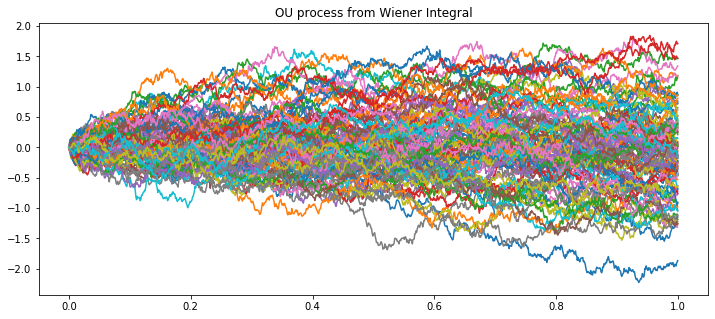

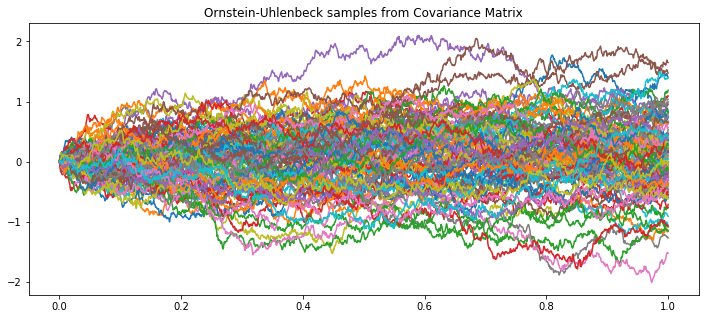

In [20]:
# OU process from Wiener integrals
T = 1
dt = 0.001
M = int(T / dt) + 1
ts = np.arange(0, T + dt, dt)

plt.figure(figsize=(12, 5))
for _ in range(100):
    # the part of int_0^t e^s d Bs, so I essentially pass in a function f(Bt,t)=e^{-t}
    int_part = ito_integral_bm(T, dt, lambda x, y: np.exp(y))
    discf = np.exp([-dt * i for i in range(M)])  # the part of e^-t
    plt.plot(ts, discf * int_part)
plt.title("OU process from Wiener Integral")
plt.show()


# codes for generating OU from covariance matrix
def generate_ou(N, T=1, dt=0.01):
    tp = np.arange(0, T + dt, dt)[1:]
    m = int(T / dt)
    ou_cov = np.array([[
        (1 - np.exp(-2 * min(s, t))) * 0.5 * np.exp(-(max(s, t) - min(s, t)))
        for s in tp
    ] for t in tp])

    A = np.linalg.cholesky(ou_cov)
    Z = np.random.standard_normal((N, m))
    B = np.dot(A, Z.T)
    zeros = np.zeros((1, N))
    B = np.vstack([zeros, B])
    return B.T


ou_samples = generate_ou(100, 1, 0.001)
plt.figure(figsize=(12, 5))
for i in ou_samples:
    plt.plot(ts, i)
plt.title("Ornstein-Uhlenbeck samples from Covariance Matrix")
plt.show()

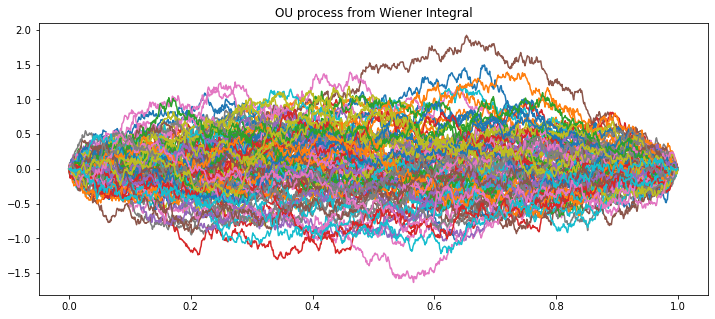

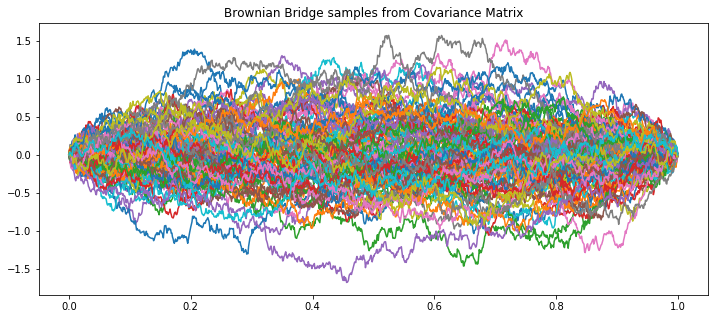

In [3]:
# Brownian bridge form Wiener integral
T = 1
dt = 0.001
M = int(T / dt) + 1
ts = np.arange(0, T + dt, dt)

plt.figure(figsize=(12, 5))
for _ in range(100):
    # the part of int_0^t 1/(1-s) d Bs, so I essentially pass in a function f(Bt,t)=1/(1-t)
    int_part = ito_integral_bm(T, dt, lambda x, y: 1 / (1 - y))
    discf = np.array([(1 - dt * i) for i in range(M)])  # the part of e^-t
    path = discf * int_part
    path[-1] = 0  # remember to set the last value to 0
    plt.plot(ts, path)
plt.title("OU process from Wiener Integral")
plt.show()


# codes for generating Brownian bridge from cov matrix
def generate_BBridge(N, T=1, dt=0.01):
    m = int(T / dt)
    tp = np.arange(0, T, dt)[1:]
    bridge_cov = np.array([[min(s, t) * (1 - max(s, t)) for s in tp]
                           for t in tp])
    A = np.linalg.cholesky(bridge_cov)
    Z = np.random.standard_normal((N, m - 1))
    B = np.dot(A, Z.T)
    zeros = np.zeros((1, N))
    B = np.vstack([zeros, B, zeros])
    return B.T


plt.figure(figsize=(12, 5))
for i in generate_BBridge(100, 1, 0.001):
    plt.plot(ts, i)
plt.title("Brownian Bridge samples from Covariance Matrix")
plt.show()

**Comments:** The result look quite promising! Numerically, we have verified that different constructions lead to the *approximately* same simulation results, verifying that Ito integral does help generate the same stochastic process from a different view.

# Project 5.6 Testing the solution to the gambler's ruin

In this project, we will look into the Brownian motion-based gambler's ruin problem.
- a) Generate poaths of Brownian motion paths with drift 1 and volatility 1 on $[0,5]$ with dt=0.01.
- b) Count the proportion of paths that has ever reached -1 (the stopping level)

## 5.6 (a)

Generate $X_t = B_t+t, t\in[0,5]$.

In [4]:
# default is X_t = B_t
def generate_bm(T, dt, mu=0, sig=1):
    m = int(T / dt)
    randomness = np.concatenate([[0], np.random.normal(0, np.sqrt(dt), m)])
    bm = randomness.cumsum()
    time_points = np.array([dt * i for i in range(m + 1)])
    res = bm * sig + mu * time_points
    return res

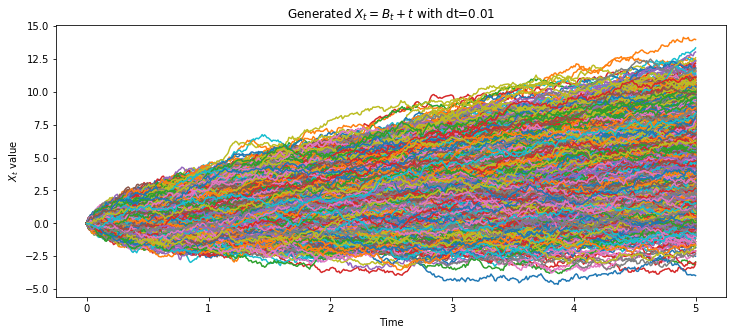

In [5]:
plt.figure(figsize=(12, 5))
for _ in range(10000):
    plt.plot(np.arange(0, 5.01, 0.01), generate_bm(5, 0.01, 1, 1))
plt.title("Generated $X_t = B_t + t$ with dt=0.01")
plt.xlabel("Time")
plt.ylabel("$X_t$ value")
plt.show()

## 5.6 (b)

In [6]:
# size dt=0.01
T = 5
dt = 0.01

cnt = 0
for _ in range(10000):
    tmp_path = generate_bm(T, dt, 1, 1)
    if np.where(tmp_path <= -1)[0].size:
        cnt += 1
print("The proportion of reaching -1: {:.4f}".format(cnt / 10000))
print("Comparison with Equation 5.29 with a probability {:.4f}".format(
    np.exp(-2)))

The proportion of reaching -1: 0.1255
Comparison with Equation 5.29 with a probability 0.1353


In [7]:
# size dt=0.001
dt = 0.001

cnt = 0
for _ in range(10000):
    tmp_path = generate_bm(T, dt, 1, 1)
    if np.where(tmp_path <= -1)[0].size:
        cnt += 1
print("The proportion of reaching -1: {:.4f}".format(cnt / 10000))
print("Comparison with Equation 5.29 with a probability {:.4f}".format(
    np.exp(-2)))

The proportion of reaching -1: 0.1296
Comparison with Equation 5.29 with a probability 0.1353


**Comments:** The empirical probability does a good job in approximating the theoretical value of $\mathbb{P}(X_{\tau}=-b)$ when we take the upper stopping level $a\to\infty$.

Also, it's interesting to note that the approximation is more accurate if we shrink the time-step $dt$, which approaches the continuous case better.

# 5.8 Tanaka's formula

In this project, we delve into some results related to Tanaka's formula.
- a) Plot the paths of $|B_t| - \int_{0}^{t}\operatorname{sgn}(B_s)\text{d}B_s$ on $[0,1]$.
- b) Plot the paths of $L_t^{\varepsilon}$ where $$L_t^{\varepsilon} = \frac{1}{2\varepsilon}|\{s\in[0,t]: |B_t|<\varepsilon\}|$$with $\varepsilon=0.001.$

## 5.8 (a)

In [8]:
# generate the Brownian motions
bms = [generate_bm(1, 1e-6) for _ in range(10)]

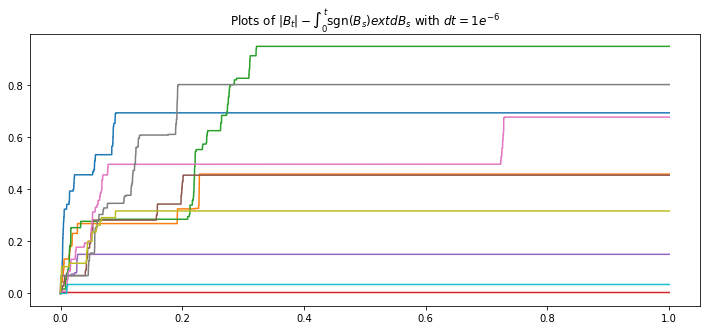

In [9]:
dt = 1e-6
plt.figure(figsize=(12, 5))

for i in range(10):
    tmp_bm = bms[i]
    increments = tmp_bm[1:] - tmp_bm[:-1]
    res = np.sign(tmp_bm[:-1]) * increments
    res = np.abs(tmp_bm) - np.concatenate([[0], res.cumsum()])
    plt.plot(np.arange(0, 1 + dt, dt), res)
plt.title(
    "Plots of $|B_t| - \int_{0}^{t}\operatorname{sgn}(B_s)\text{d}B_s$ with $dt=1e^{-6}$"
)
plt.show()

## 5.8 (b)
- We still use the brownian motions generated above.

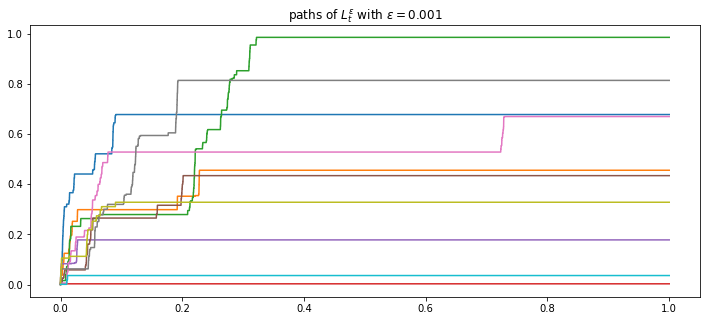

In [10]:
eps = 1e-3
dt = 1e-6

plt.figure(figsize=(12, 5))
for i in range(10):
    tmp_bm = bms[i]
    total_count = 0
    res = [0 for _ in range(len(tmp_bm))]
    for i in range(len(tmp_bm)):
        if np.abs(tmp_bm[i]) < eps:
            total_count += 1
        res[i] = 1 / (
            2 * eps
        ) * total_count * dt  # to measure the time, we have to multiply the dt term.
    plt.plot(np.arange(0, 1 + dt, dt), res)
plt.title("paths of $L_t^{\\varepsilon}$ with $\\varepsilon=0.001$")
plt.show()

**Comments:** We can clearly observe the approximation behavior from the plot in part (b) to part (a).